In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

In [3]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, image_list=None, transform=None):
        self.image_dir = image_dir
        self.image_fns = image_list if image_list is not None else os.listdir(image_dir)
        self.transform = transform or self._default_transform()

    def __len__(self):
        return len(self.image_fns)


    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)

        # Split the combined image into cityscape and label
        cityscape, label = image[:,:int(image.shape[1]/2)],image[:,int(image.shape[1]/2):]

        if self.transform:
            cityscape = self.transform(Image.fromarray(cityscape))

        # Convert label to tensor
        label = torch.from_numpy(label).long()

        return cityscape, label

    def _default_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])


In [ ]:
def create_cityscapes_dataloaders(base_path, batch_size=8, num_workers=4):

    if not os.path.exists(os.path.join(base_path, 'cityscapes_data')):
        raise ValueError("Citispace data is not downloaded. Please download the data.")
    else:
        print("Citispace data is previously downloaded...!")
        data_dir = os.path.join(base_path, 'cityscapes_data')

    train_images = os.listdir(os.path.join(data_dir, "train"))
    val_images = os.listdir(os.path.join(data_dir,'val'))
    test_images = val_images[:int(len(val_images)/2)]
    val_images = val_images[int(len(val_images)/2):]
    np.random.seed(42)
    np.random.shuffle(train_images)
    np.random.shuffle(val_images)

    train_dataset = CityscapesDataset(
        os.path.join(data_dir, "train"),
        image_list=train_images
    )
    val_dataset = CityscapesDataset(
        os.path.join(data_dir, "val"),
        image_list=val_images
    )
    test_dataset = CityscapesDataset(
        os.path.join(data_dir, "val"),
        image_list=test_images
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader


In [6]:
# Load the data
base_path = 'data'  # base path of where the cityscapes dataset is stored
train_loader, val_loader, test_loader = create_cityscapes_dataloaders(
    base_path=base_path,
    batch_size=8,
    num_workers=4
)

Citispace data is previously downloaded...!


In [7]:
# Get a batch of data and print sizes
images, masks = next(iter(train_loader))
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

Image size: torch.Size([8, 3, 256, 256])
Mask size: torch.Size([8, 256, 256, 3])


In [8]:
# Get Cityscapes classes from the dataset
CITYSCAPES_CLASSES = {
    0: 'background',
    1: 'road',
    2: 'sidewalk',
    3: 'building',
    4: 'wall',
    5: 'fence',
    6: 'pole',
    7: 'traffic light',
    8: 'traffic sign',
    9: 'vegetation',
    10: 'terrain',
    11: 'sky',
    12: 'person',
    13: 'rider',
    14: 'car',
    15: 'truck',
    16: 'bus',
    17: 'train',
    18: 'motorcycle',
    19: 'bicycle',
    255: 'ignore'  # Special ignore class
}


# Create a color palette for visualization
COLOR_PALETTE = {
    0: (0, 0, 0),        # background: black
    1: (128, 64, 128),   # road: purple
    2: (244, 35, 232),   # sidewalk: pink
    3: (70, 70, 70),     # building: dark gray
    4: (102, 102, 156),  # wall: dark blue-gray
    5: (190, 153, 153),  # fence: light pink
    6: (153, 153, 153),  # pole: gray
    7: (250, 170, 30),   # traffic light: orange
    8: (220, 220, 0),    # traffic sign: yellow
    9: (107, 142, 35),   # vegetation: green
    10: (152, 251, 152), # terrain: light green
    11: (70, 130, 180),  # sky: blue
    12: (220, 20, 60),   # person: red
    13: (255, 0, 0),     # rider: bright red
    14: (0, 0, 142),     # car: dark blue
    15: (0, 0, 70),      # truck: darker blue
    16: (0, 60, 100),    # bus: medium blue
    17: (0, 80, 100),    # train: blue
    18: (0, 0, 230),     # motorcycle: bright blue
    19: (119, 11, 32),   # bicycle: dark red
    255: (0, 0, 0)       # ignore: black
}

# Function to plot colormap legend
def plot_colormap_legend():
    num_cols = 5
    num_rows = (len(CITYSCAPES_CLASSES) + num_cols - 1) // num_cols
    fig, ax = plt.subplots(figsize=(15, num_rows * 2))

    for idx, (class_id, class_name) in enumerate(CITYSCAPES_CLASSES.items()):
        if class_id == 255:  # Skip ignore class in visualization
            continue
        row = idx // num_cols
        col = idx % num_cols
        color = [x/255.0 for x in COLOR_PALETTE[class_id]]
        ax.add_patch(plt.Rectangle((col, -row), 1, 1, facecolor=color))
        ax.text(col + 0.5, -row + 0.5, class_name,
                ha='center', va='center', rotation=45, fontsize=10, color='white' if sum(color) < 1.5 else 'black')

    ax.set_xlim(0, num_cols)
    ax.set_ylim(-num_rows, 1)
    ax.axis('off')
    plt.title('Cityscapes Classes Color Map')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_predictions(images, masks, predictions=None, n_samples=4):
    n_rows = 2 if predictions is None else 3
    fig, axes = plt.subplots(n_rows, n_samples, figsize=(15, 5*n_rows))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()

        axes[1, i].imshow(mask)
        axes[1, i].axis('off')
        axes[1, i].set_title('Ground Truth')

        # Plot prediction if available
        if predictions is not None:
            pred = torch.argmax(predictions[i], dim=0).cpu().numpy()
            colored_pred = np.zeros((*pred.shape, 3), dtype=np.float32)  # Changed to float32

            axes[2, i].imshow(colored_pred)
            axes[2, i].axis('off')
            axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [21]:
# Plot the colormap legend and some sample images
# plot_colormap_legend()

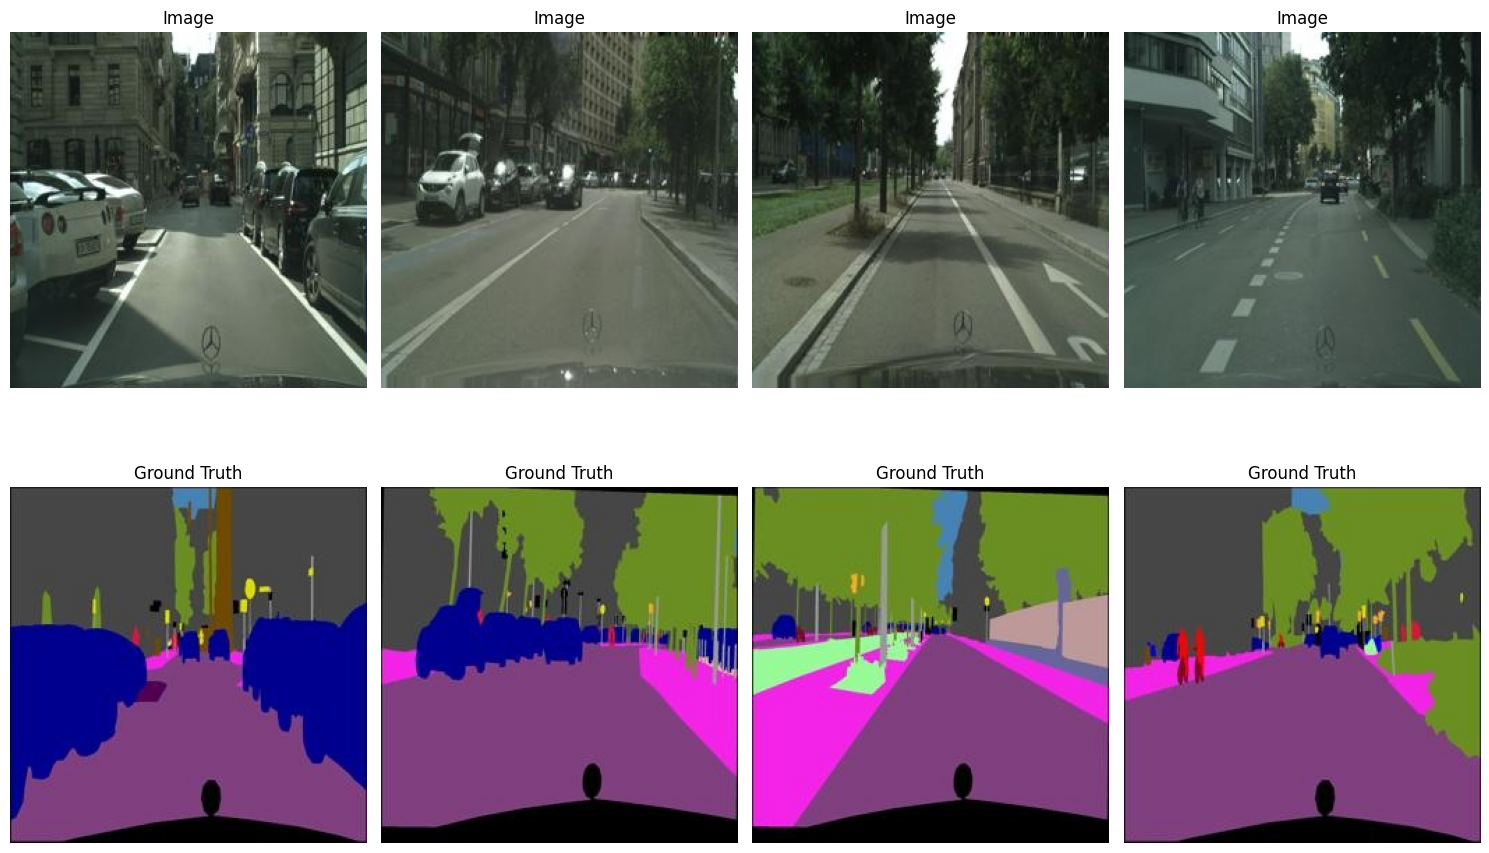

In [10]:
plot_predictions(images, masks, n_samples=4)

In [11]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(output, target, num_classes=3):
    output = output.to(device)
    target = target.to(device)

    # Ensure output has the correct number of channels
    if output.shape[1] != num_classes:
        output = output[:, :num_classes, :, :]

    pred = output.argmax(dim=1)
    target = target.argmax(dim=1)  # Assuming target is one-hot encoded

    iou = torch.zeros(num_classes, device=device)
    dice = torch.zeros(num_classes, device=device)
    precision = torch.zeros(num_classes, device=device)
    recall = torch.zeros(num_classes, device=device)
    f1 = torch.zeros(num_classes, device=device)

    for class_id in range(num_classes):
        pred_class = (pred == class_id)
        target_class = (target == class_id)

        intersection = (pred_class & target_class).float().sum()
        union = (pred_class | target_class).float().sum()

        iou[class_id] = intersection / (union + 1e-7)
        dice[class_id] = (2 * intersection) / (pred_class.float().sum() + target_class.float().sum() + 1e-7)

        true_positives = (pred_class & target_class).float().sum()
        false_positives = (pred_class & ~target_class).float().sum()
        false_negatives = (~pred_class & target_class).float().sum()

        precision[class_id] = true_positives / (true_positives + false_positives + 1e-7)
        recall[class_id] = true_positives / (true_positives + false_negatives + 1e-7)
        f1[class_id] = 2 * (precision[class_id] * recall[class_id]) / (precision[class_id] + recall[class_id] + 1e-7)

    mean_iou = iou.mean().item()
    mean_dice = dice.mean().item()
    mean_precision = precision.mean().item()
    mean_recall = recall.mean().item()
    mean_f1 = f1.mean().item()

    return {
        'iou': mean_iou,
        'dice': mean_dice,
        'precision': mean_precision,
        'recall': mean_recall,
        'f1': mean_f1
    }

import tqdm
def validate(model, loader, criterion, device, n_classes):
    model.eval()
    total_loss = 0
    batch_count = 0
    total_metrics = {}

    with tqdm.tqdm(loader) as pbar:
        with torch.no_grad():
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                total_loss += loss.item()
                batch_metrics = calculate_metrics(outputs, masks, n_classes)
                for k, v in batch_metrics.items():
                    if k in total_metrics:
                        total_metrics[k] = (total_metrics[k] * batch_count + v) / (batch_count + 1)
                    else:
                        total_metrics[k] = v
                batch_count += 1
    return total_loss / len(loader), total_metrics

def train_one_epoch(model, loader, criterion, optimizer, device, n_classes):
    model.train()
    total_loss = 0
    batch_count = 0
    total_metrics = {}
    with tqdm.tqdm(loader) as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_metrics = calculate_metrics(outputs, masks, n_classes)
            for k, v in batch_metrics.items():
                if k in total_metrics:
                    total_metrics[k] = (total_metrics[k] * batch_count + v) / (batch_count + 1)
                else:
                    total_metrics[k] = v
            batch_count += 1
            # Update progress bar with just the loss
            pbar.set_postfix({'loss': loss.item()})

    return total_loss / len(loader), total_metrics

In [12]:
from early_stopping import EarlyStopping
# Training setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 3
model = UNet(n_channels=3, n_classes=num_classes, dropout_rate=0.3, use_batchnorm=True).to(device)
criterion = CrossEntropyLoss()  # Ignore index for Cityscapes
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
# Training history
history = {
    'train_loss': [],
    'train': [],
    'val_loss': [],
    'val': [],
    'learning_rates': []

}

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, num_classes)
    print("Running validation")
    # Validation phase
    val_loss, val_metrics = validate(model, val_loader, criterion, device, num_classes)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    for k, v in train_metrics.items():
        history[f'train_{k}'] = v
    for k, v in val_metrics.items():
        history[f'val_{k}']
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train IoU: {train_metrics['iou']:.4f}")
    print(f"Train Dice: {train_metrics['dice']:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Dice: {val_metrics['dice']:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'cityscapes_ce_model.pth')
import pickle
with open('cityscapes_ce_training_history.pkl', 'wb') as f:
    pickle.dump(history, f)


Epoch 1/1


  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/372 [00:06<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4

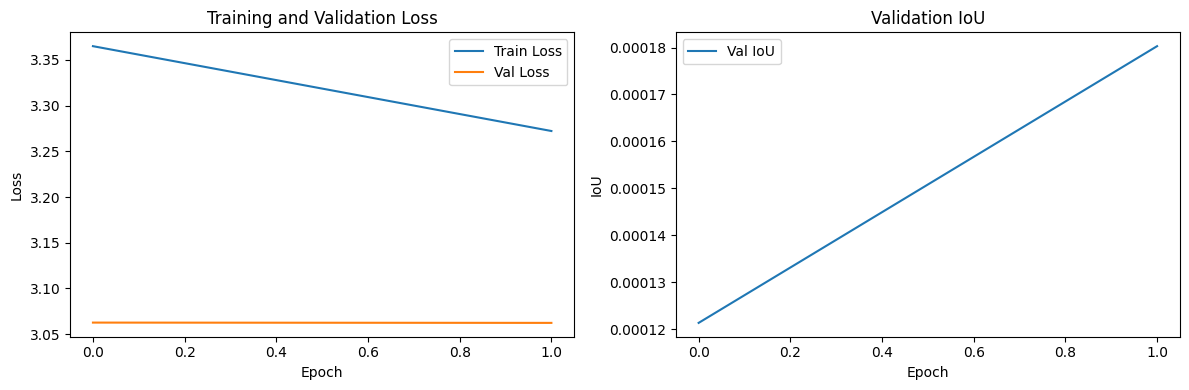

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Validation IoU')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model and run predictions
import torch
from unet import UNet
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        colored_mask = np.zeros((*mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            if class_id != 255:  # Skip ignore label
                colored_mask[mask == class_id] = [x/255 for x in color]
        axes[i, 1].imshow(colored_mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        colored_pred = np.zeros((*pred_mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            if class_id != 255:  # Skip ignore label
                colored_pred[pred_mask == class_id] = [x/255 for x in color]
        axes[i, 2].imshow(colored_pred)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

/tmp/ipykernel_52161/1798618319.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('cityscapes_ce_model.pth'))


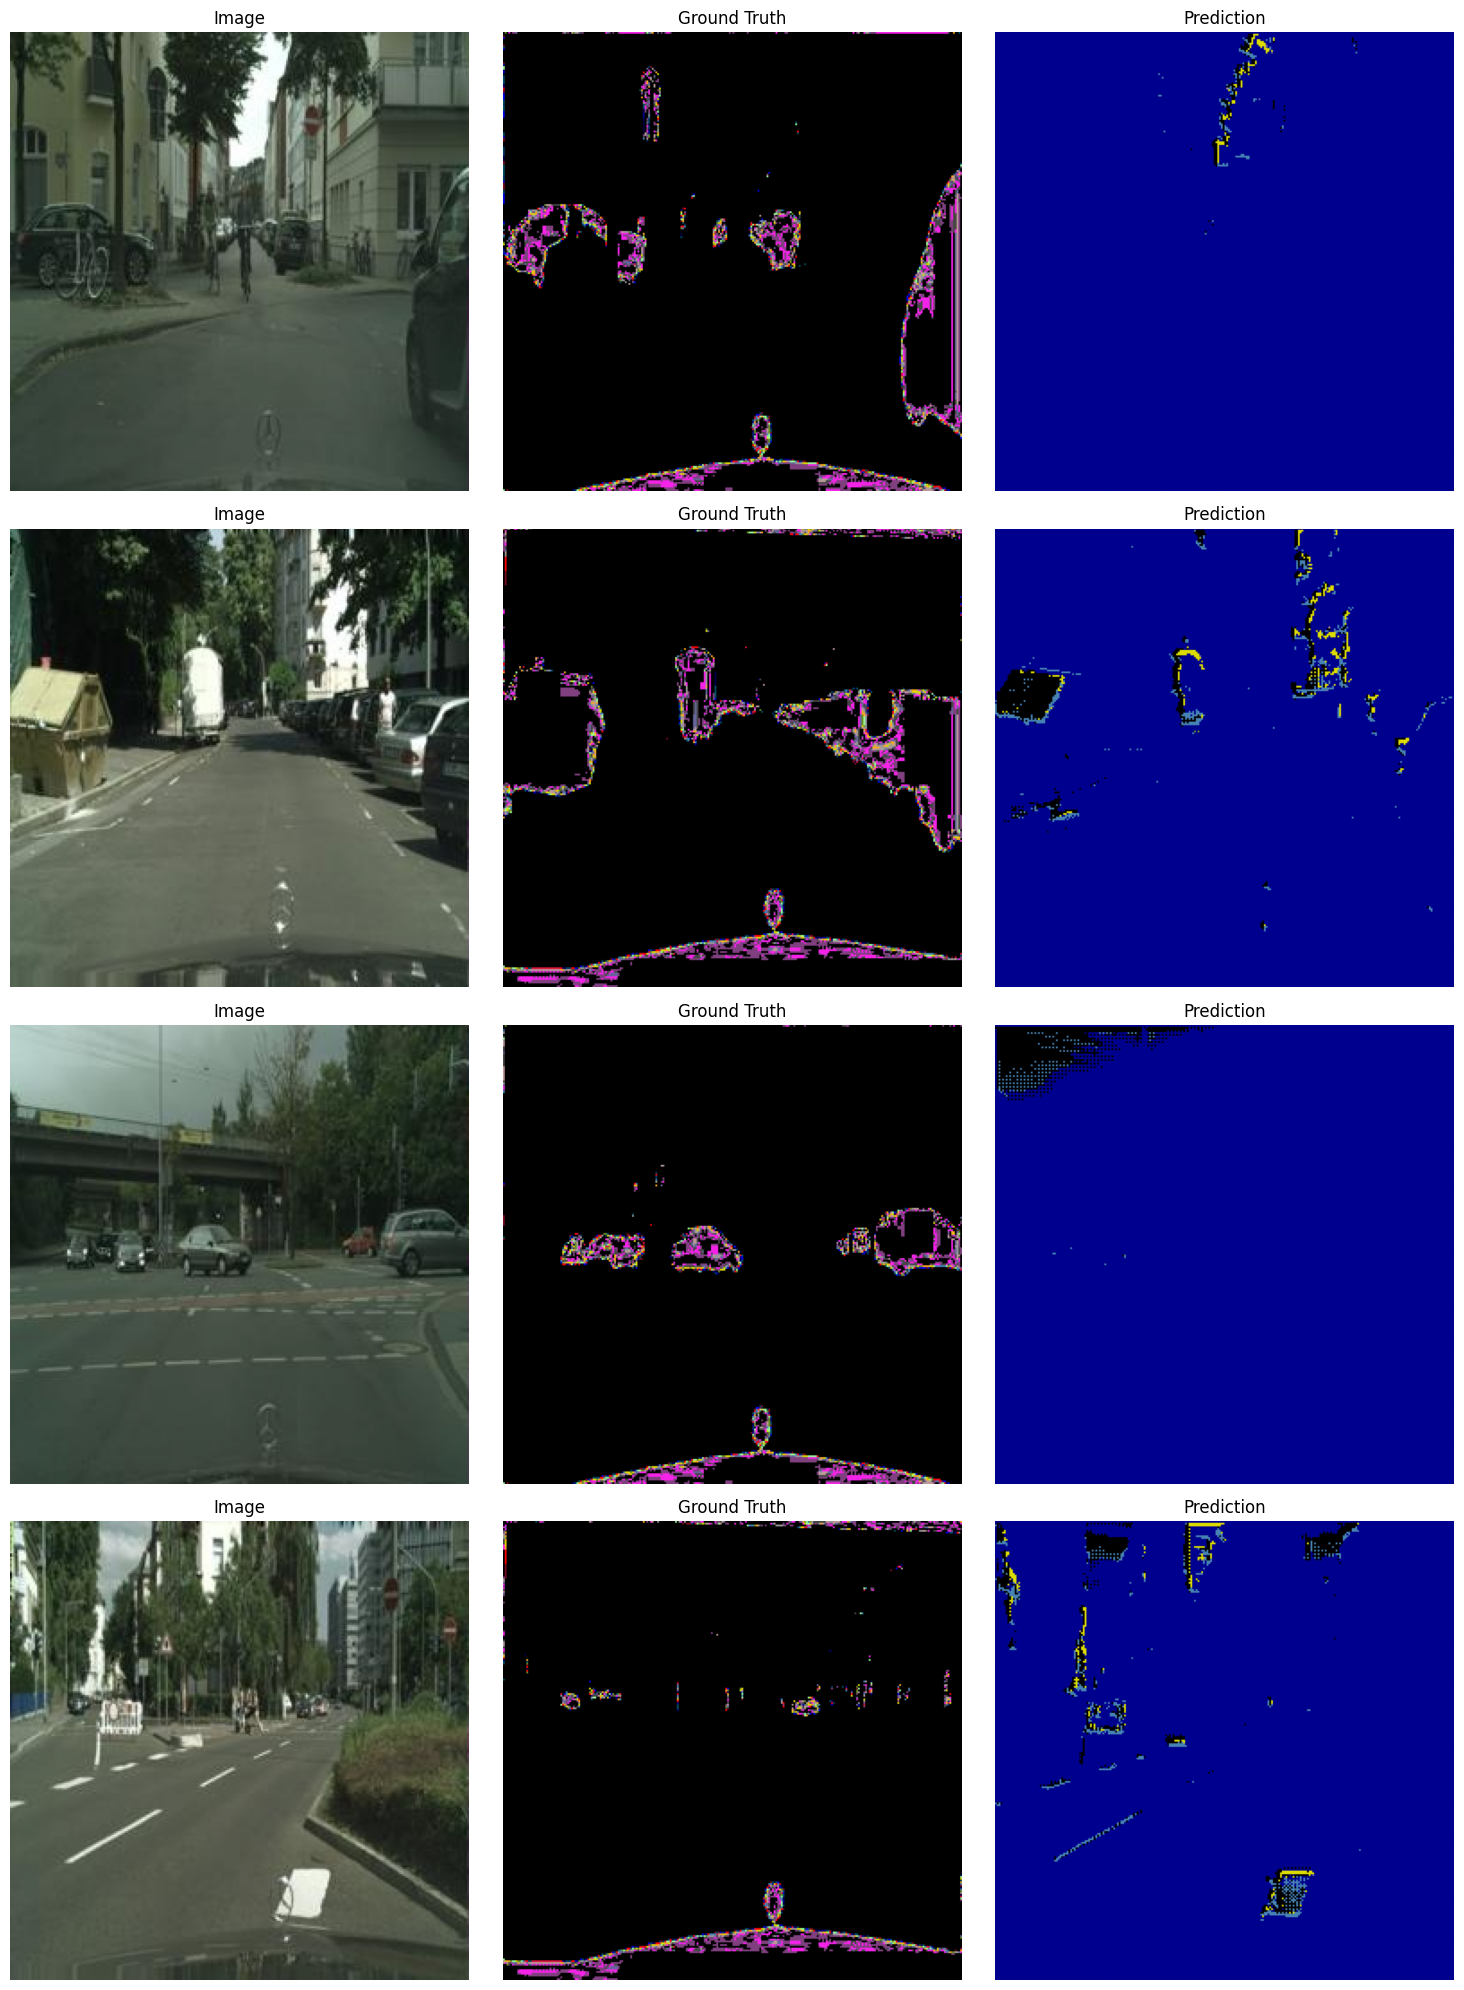

100%|██████████| 32/32 [02:59<00:00,  5.62s/it]



Test Set Metrics:
Loss: 2.9122
IoU: 0.0015
Dice Score: 0.0030
Precision: 0.0500
Recall: 0.0509
F1 Score: 0.0030

Per-class IoU scores:
background: 0.0261
road: 0.0000
sidewalk: 0.0000
building: 0.0000
wall: 0.0003
fence: 0.0000
pole: 0.0000
traffic light: 0.0000
traffic sign: 0.0018
vegetation: 0.0000
terrain: 0.0000
sky: 0.0011
person: 0.0000
rider: 0.0000
car: 0.0011
truck: 0.0000
bus: 0.0000
train: 0.0000
motorcycle: 0.0000
bicycle: 0.0000


In [ ]:
# Load the best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = UNet(n_channels=3, n_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load('cityscapes_ce_model.pth'))
loaded_model.eval()

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

# Calculate and print metrics for the test set
criterion = CrossEntropyLoss(ignore_index=255)
test_loss, test_metrics = validate(loaded_model, test_loader, criterion, device, num_classes)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_id, class_name in CITYSCAPES_CLASSES.items():
    if class_id != 255:  # Skip ignore class
        iou_key = f'class_{class_id}_iou'
        if iou_key in test_metrics:
            print(f"{class_name}: {test_metrics[iou_key]:.4f}")

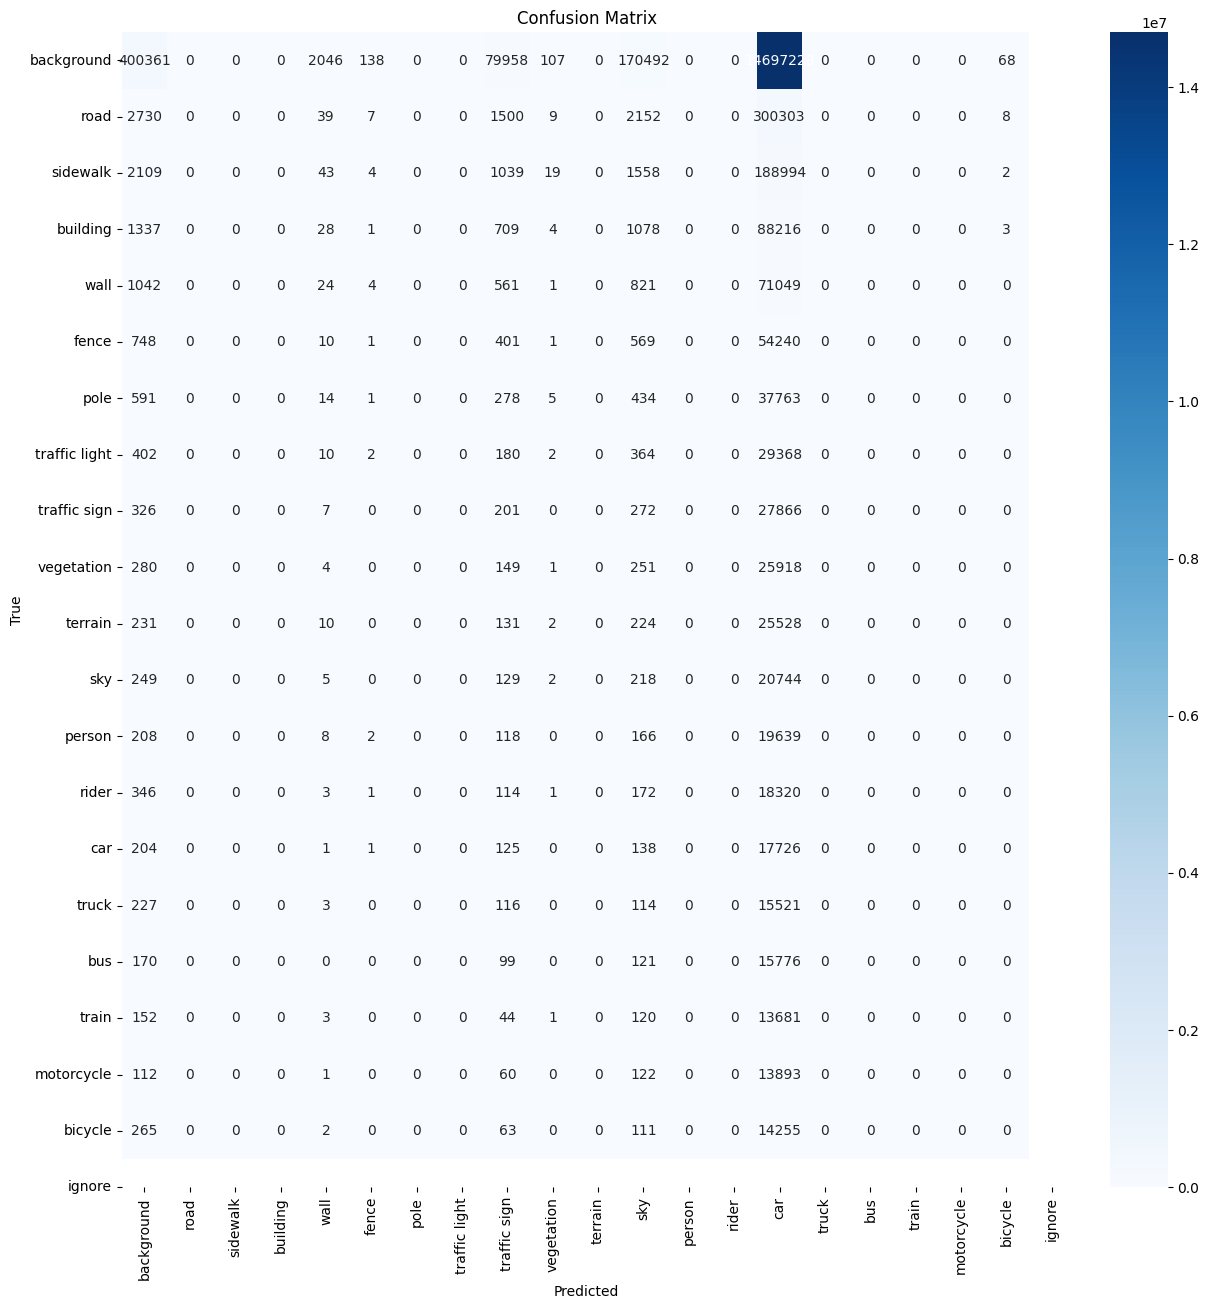

In [ ]:
import seaborn as sns

def plot_confusion_matrix(metrics):
    plt.figure(figsize=(15, 15))
    conf_matrix = metrics['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CITYSCAPES_CLASSES.values(), yticklabels=CITYSCAPES_CLASSES.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_metrics)